In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import torch
from neuralop.data.datasets.custom_darcy import CustomDarcyDataset, load_darcy_flow
import matplotlib.pyplot as plt
from neuralop.models import FNO, TFNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss, VinoDarcyLoss

In [2]:
resolution = 64

train_loader, test_loaders, data_processor = load_darcy_flow(
    root_dir="./data/",
    dataset_name='darcy_ZD_PWC',
    n_train=1000,
    n_tests=[50],
    batch_size=100,
    test_batch_sizes=[50],
    train_resolution=resolution,
    test_resolutions=[resolution],
    encode_input=True,
    encode_output=False,
)

Downloading...
From (original): https://drive.google.com/uc?id=1qsstWhpdYRkj7dTSeVpfDFWknj0LpCPw
From (redirected): https://drive.google.com/uc?id=1qsstWhpdYRkj7dTSeVpfDFWknj0LpCPw&confirm=t&uuid=09f2a30a-2290-43f0-befc-fc58cbc912d4
To: /home/jaeminseo/Documents/neuraloperator-main-main/projects/data/darcy_ZD_PWC_train_64.pt
100%|██████████| 65.5M/65.5M [00:11<00:00, 5.54MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hQzdQpudGTBZ7x0nURPzlV5DTcqcb1sm
To: /home/jaeminseo/Documents/neuraloperator-main-main/projects/data/darcy_ZD_PWC_test_64.pt
100%|██████████| 3.28M/3.28M [00:00<00:00, 4.84MB/s]

Loading test db for resolution 64 with 50 samples 



/home/jaeminseo/Documents/neuraloperator-main-main/neuralop/data/datasets/pt_dataset.py:125: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  x_train = x_train[train_input_indices]
/home/jaeminseo/Documents/neuraloperator-main-main/neuralop/data/datasets/pt_dataset.py:148: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  y_

In [ ]:
class HardDirichletFNO(FNO):

    def forward(self, x, output_shape=None, **kwargs):
        x = super().forward(x, output_shape=output_shape, **kwargs)

        interior = torch.ones_like(x)
        interior[:, :,  0, :] = 0
        interior[:, :, -1, :] = 0
        interior[:, :, :,  0] = 0
        interior[:, :, :, -1] = 0

        return x * interior

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = HardDirichletFNO(
    n_modes=(16, 16),
    hidden_channels=64,
    in_channels=1,
    out_channels=1,
)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 4769473 parameters.


In [5]:
n_epochs = 100
optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = VinoDarcyLoss()
eval_losses={'h1': h1loss, 'l2': l2loss}

In [6]:
import wandb
from datetime import datetime

wandb.init(
    project='Samsung_Project',
    name=f'VINO_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
)

wandb: Currently logged in as: tjwoals217 (tjwoals217-Chung-Ang University) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
trainer = Trainer(model=model, 
                  n_epochs=n_epochs,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=True,
                  eval_interval=1,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50] samples         on resolutions [64].


/home/jaeminseo/anaconda3/envs/testPINN/lib/python3.10/site-packages/tltorch/factorized_tensors/factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.__class__(self.tensor[indices])
/home/jaeminseo/Documents/neuraloperator-main-main/neuralop/layers/spectral_convolution.py:486: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/pyt

Raw outputs of shape torch.Size([100, 1, 64, 64])
[0] time=1.04, avg_loss=13.6741, train_err=1367.4124
Eval: 64_h1=7.5030, 64_l2=2.0467
[1] time=0.76, avg_loss=0.1774, train_err=17.7407
Eval: 64_h1=5.0804, 64_l2=2.5630
[2] time=0.75, avg_loss=0.0396, train_err=3.9552
Eval: 64_h1=2.1252, 64_l2=0.5160
[3] time=0.75, avg_loss=0.0122, train_err=1.2246
Eval: 64_h1=1.4341, 64_l2=1.1997
[4] time=0.75, avg_loss=0.0038, train_err=0.3786
Eval: 64_h1=0.9243, 64_l2=0.6697
[5] time=0.76, avg_loss=0.0007, train_err=0.0740
Eval: 64_h1=0.8689, 64_l2=0.8291
[6] time=0.76, avg_loss=-0.0004, train_err=-0.0426
Eval: 64_h1=0.7737, 64_l2=0.6527
[7] time=0.76, avg_loss=-0.0009, train_err=-0.0917
Eval: 64_h1=0.7683, 64_l2=0.7272
[8] time=0.74, avg_loss=-0.0012, train_err=-0.1167
Eval: 64_h1=0.7002, 64_l2=0.5946
[9] time=0.75, avg_loss=-0.0013, train_err=-0.1311
Eval: 64_h1=0.6768, 64_l2=0.5996
[10] time=0.76, avg_loss=-0.0014, train_err=-0.1410
Eval: 64_h1=0.6520, 64_l2=0.5702
[11] time=0.76, avg_loss=-0.0015

{'train_err': -0.264246928691864,
 'avg_loss': -0.00264246928691864,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.7594533348456025,
 '64_h1': tensor(0.2072, device='cuda:0', dtype=torch.float64),
 '64_l2': tensor(0.0947, device='cuda:0', dtype=torch.float64)}

In [8]:
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


64_h1,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
64_l2,▇█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█████████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
time,█▂▁▁▂▁▂▂▁▁▂▁▁▁▁▁▁▂▁▁▂▁▂▂▁▁▂▁▂▁▁▁▂▂▁▁▁▁▁▂
train_err,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
64_h1,0.20724
64_l2,0.09472
avg_loss,-0.00264
lr,0
time,0.75945


L2 error (0) : 0.06779677595090103
L2 error (1) : 0.060535711303649285
L2 error (2) : 0.10755343071695159


/home/jaeminseo/anaconda3/envs/testPINN/lib/python3.10/site-packages/tltorch/factorized_tensors/factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.__class__(self.tensor[indices])
/home/jaeminseo/Documents/neuraloperator-main-main/neuralop/layers/spectral_convolution.py:486: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/pyt

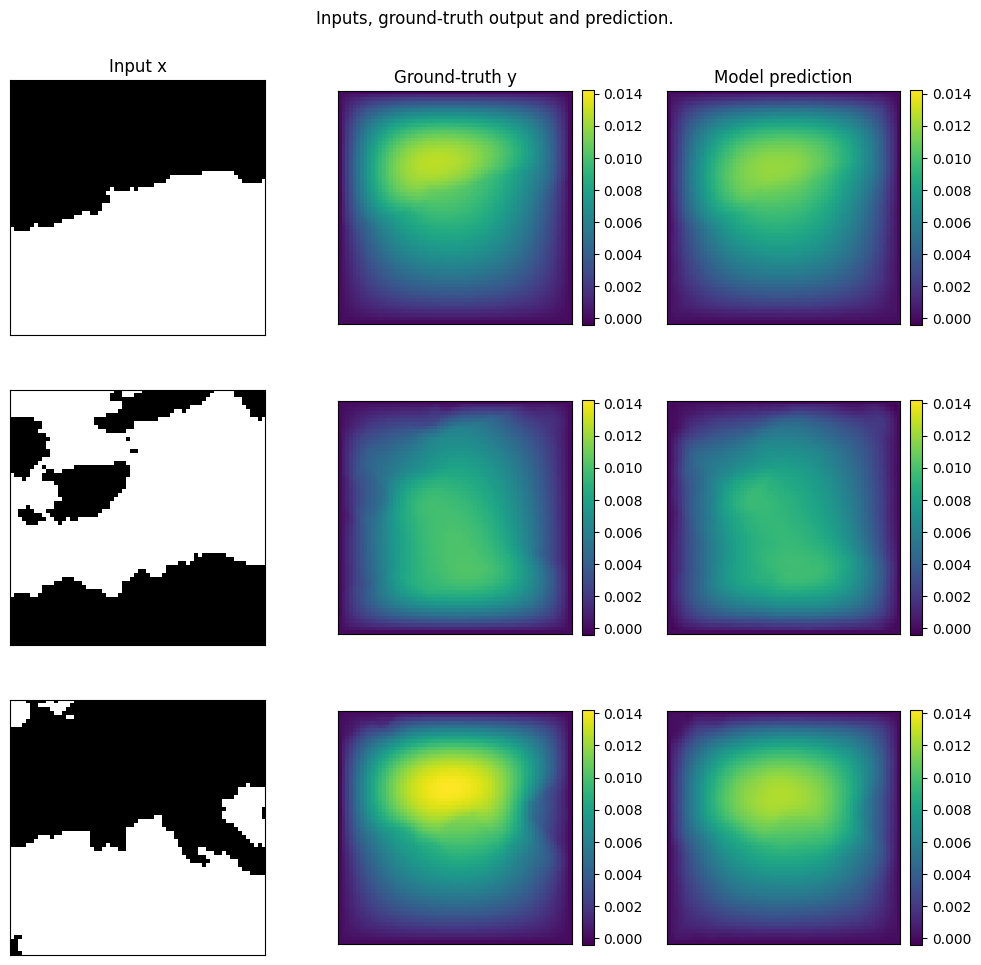

In [9]:
test_samples = test_loaders[64].dataset

# Step 1: Compute global min and max for consistent color scaling
vmin, vmax = float('inf'), float('-inf')
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x']
    y = data['y']
    out = model(x)

    # y = data_processor.out_normalizer.inverse_transform(y).squeeze().detach()
    # out = data_processor.out_normalizer.inverse_transform(out).squeeze().detach()

    vmin = min(vmin, y.min().item(), out.min().item())
    vmax = max(vmax, y.max().item(), out.max().item())

# Step 2: Plot with consistent vmin/vmax and add colorbars
fig = plt.figure(figsize=(10, 10))

for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x'].to(device)
    y = data['y'].to(device)
    out = model(x).squeeze().detach()

    # y = data_processor.out_normalizer.inverse_transform(y)
    # out = data_processor.out_normalizer.inverse_transform(out)

    # Input x
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    im = ax.imshow(x[0][0].cpu(), cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])
    
    # Ground-truth y
    ax = fig.add_subplot(3, 3, index * 3 + 2)
    im = ax.imshow(y.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Model prediction
    ax = fig.add_subplot(3, 3, index * 3 + 3)
    im = ax.imshow(out.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    print(f'L2 error ({index}) : {torch.norm(out - y) / torch.norm(y)}')

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
plt.show()